<font color='blue'> <h2>**A Neural Network Model for approximating eigenvalues**</h2></font>

**by Julián Fernández Bonder and Ariel Salort**

**Notebook corresponding to the article:**

**"*A PINNs approach for the computation of eigenvalues in elliptic problems.*"**

In this notebook, we use a fully connected neural network to approximate the eigenfunctions of the following eigenvalue problem with Dirichlet boundary conditions on a domain $\Omega \subset \mathbb{R}^n$:
<font color='blue'>
$$
\begin{cases}
- \Delta u + V(x) u = E u & \text{in } \Omega, \\
u = 0 & \text{on } \partial \Omega,
\end{cases}
$$
</font>
where <font color='green'>$V : \mathbb{R}^n \to \mathbb{R}$ </font>is a given potential function and <font color='green'>$E$</font> is the eigenvalue parameter.

For suitable choices of the potential $V$, it is well known that there exists an infinite sequence of increasing eigenvalues:
$$
E_1 < E_2 < E_3 < \cdots \nearrow \infty.
$$

<font color='blue'>**The neuronal network model**</font>

To approximate the eigenvalues contained within a fixed interval $[E_*, E^*]$, we employ a fully connected neural network. We begin with a network composed of four hidden layers, each with 128 neurons and $\tanh$ activation functions.

The <font color='green'>**forward method**</font> defines how the neural network computes the approximate eigenfunction value at a given point \((x, y)\). The architecture is designed so that the output function automatically satisfies the Dirichlet boundary condition $u = 0$ on $\partial \Omega$.

<font color='red'> **Example 1: harmonic potential in the unit disk** </font>

In our first example, we consider the eigenvalue problem on the unit disk in $\mathbb{R}^2$,
<font color='green'>
$$
\Omega = \{ (x,y) \in \mathbb{R}^2 : x^2 + y^2 \leq 1 \},
$$
</font>
with the quadratic potential
<font color='green'>
$$
V(x,y) = \frac{1}{2} (x^2 + y^2).
$$
</font>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

class EigenFunctionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            nn.init.zeros_(m.bias)

    def forward(self, xy):
        x, y = xy[:, 0:1], xy[:, 1:2]
        u = self.net(xy)
        return (1 - x**2 - y**2) * u

<font color='blue'>**Potential function**</font>

We define the potential function corresponding to the problem.

In [2]:
def V1(xy, omega=1.0):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return 0.5 * omega**2 * (x**2 + y**2)

<font color='blue'>**Sample function**</font>

The function **sample_points(n)** generates $n$ points uniformly distributed inside the unit disk. These points are used to evaluate the model and compute the loss during training.

In [3]:
def sample_points(n):
    r = torch.sqrt(torch.rand(n, 1))
    theta = 2 * np.pi * torch.rand(n, 1)
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    return torch.cat([x, y], dim=1)

<font color='blue'>**Loss function**</font>

The function **`loss_fn`** computes the loss used to train the neural network to approximate eigenfunctions of the eigenvalue problem, that is,
$$
\bar  \Lambda(u,E)=\int_\Omega (\Delta u - Vu + Eu)^2\,dx + \mu\left(\int_\Omega u^2\,dx-1\right)^2.
$$

**Inputs:**
- <font color='blue'> model</font>: the neural network approximating $u(x, y)$
- <font color='blue'> xy</font>: sample points in $\Omega$, with gradients enabled
- <font color='blue'>$E_{\text{val}}$</font>: eigenvalue parameter
- <font color='blue'>V</font>: potential evaluated at the sample points
- <font color='blue'>\mu</font>: penalty parameter for normalization

**Output:**
- the total loss
- the individual residual  
- normalization losses for monitoring.

In [4]:
def loss_fn(model, xy, E_val, V, mu=100.0):
    xy.requires_grad_(True)
    u = model(xy)
    grad_u = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    laplace_u = sum([
        torch.autograd.grad(grad_u[:, i:i+1], xy, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, i:i+1]
        for i in range(2)
    ])
    residual = laplace_u - V * u + E_val * u
    loss_residual = (residual**2).mean()
    loss_norm = ((u**2).mean() - 1)**2
    return loss_residual + mu * loss_norm, loss_residual.item(), loss_norm.item()

<font color='blue'>**Training function**</font>

The function **`train`** performs the optimization of the neural network to approximate an eigenfunction of the operator $-\Delta + V(x)$, associated with a given eigenvalue $E$.

**Inputs:**
- <font color='blue'>model</font>: the neural network to be trained
- <font color='blue'>$E_{\text{val}}$</font>: target eigenvalue
- <font color='blue'>$V_{\text{tensor}}$</font>: potential function as a PyTorch-compatible callable
- <font color='blue'>$n_{\text{epochs}}$</font>: maximum number of training steps
- <font color='blue'>lr</font>: learning rate for the Adam optimizer
- <font color='blue'>$\mu$</font>: penalty for the normalization constraint
- <font color='blue'>early\_stopping\_patience</font>: number of epochs without improvement before stopping
- <font color='blue'>tol</font>: tolerance for improvement in loss

**Training Loop:**
At each epoch:
1. Sample $512$ points uniformly in the domain (this quantity can be increased to improve accuracy)
2. Evaluate the potential $V(x, y)$ at these points.
3. Compute the total loss using `loss_fn`, combining PDE residual and normalization constraint.
4. Perform a gradient descent step using the Adam optimizer.
5. Track the best loss and apply early stopping if no improvement is seen for a fixed number of epochs.

**Output:**  
- <font color='blue'>res</font>: final values of the residual loss and normalization loss.
- <font color='blue'>norm</font>: this value quantifies the error in the normalization constraint $\|u\|_{L^2} = 1$.

In [5]:
def train(model, E_val, V_tensor, n_epochs=2000, lr=1e-3, mu=100.0, early_stopping_patience=300, tol=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    counter = 0
    for epoch in range(n_epochs):
        xy = sample_points(512)
        V = V_tensor(xy).detach()
        optimizer.zero_grad()
        loss, res, norm = loss_fn(model, xy, E_val, V, mu)
        loss.backward()
        optimizer.step()
        if loss.item() < best_loss - tol:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
        if counter > early_stopping_patience:
            break
    return res, norm

<font color='blue'>**Main loop**</font>

We train the neural network over a range of eigenvalues $E \in [E_*, E^*]$ sampled at a fixed number of points. For each $E$, the model approximates the corresponding eigenfunction under the potential $V$.

To accelerate training, the weights from the previous model are transferred as initialization, except every 50th step—where training restarts from scratch to prevent error accumulation. This frequency can be adjusted to balance training speed and precision. Residuals and normalization errors are recorded for each eigenvalue.


In [6]:
E_min, E_max, E_step = 0.0, 33.0, 100
lambdas = np.linspace(E_min, E_max, E_step)
residuals, trained_models = [], []

model = EigenFunctionNN()
for i, lam in enumerate(lambdas):
    if i > 0 and i % 50 !=0:
        new_model = EigenFunctionNN()
        new_model.load_state_dict(model.state_dict())
        model = new_model
    else:
        model = EigenFunctionNN()
    res, norm_err = train(model, E_val=lam, V_tensor=V1)
    print(f"E={lam:.2f} -> residual={res:.4e}, norm_err={norm_err:.2e}")
    residuals.append(res)
    trained_models.append(model)

lambda=0.00 -> residual=2.6396e+01, norm_err=5.98e-02
lambda=0.33 -> residual=2.7458e+01, norm_err=1.31e-02
lambda=0.67 -> residual=2.6337e+01, norm_err=1.53e-03
lambda=1.00 -> residual=2.0716e+01, norm_err=2.13e-02
lambda=1.33 -> residual=1.9765e+01, norm_err=2.66e-03
lambda=1.67 -> residual=1.7353e+01, norm_err=1.31e-03
lambda=2.00 -> residual=1.5590e+01, norm_err=9.20e-05
lambda=2.33 -> residual=1.0966e+01, norm_err=1.94e-02
lambda=2.67 -> residual=9.7577e+00, norm_err=4.56e-03
lambda=3.00 -> residual=8.6385e+00, norm_err=5.08e-04
lambda=3.33 -> residual=6.1579e+00, norm_err=5.40e-03
lambda=3.67 -> residual=4.6749e+00, norm_err=4.36e-03
lambda=4.00 -> residual=3.9783e+00, norm_err=6.86e-03
lambda=4.33 -> residual=2.3418e+00, norm_err=1.77e-03
lambda=4.67 -> residual=1.4812e+00, norm_err=1.80e-03
lambda=5.00 -> residual=7.4294e-01, norm_err=5.87e-03
lambda=5.33 -> residual=3.3867e-01, norm_err=2.72e-03
lambda=5.67 -> residual=1.4354e-01, norm_err=3.97e-04
lambda=6.00 -> residual=6.99

<font color='blue'>**Plot of residuals vs E's**</font>

We plot the loss values computed for different values of $E$.

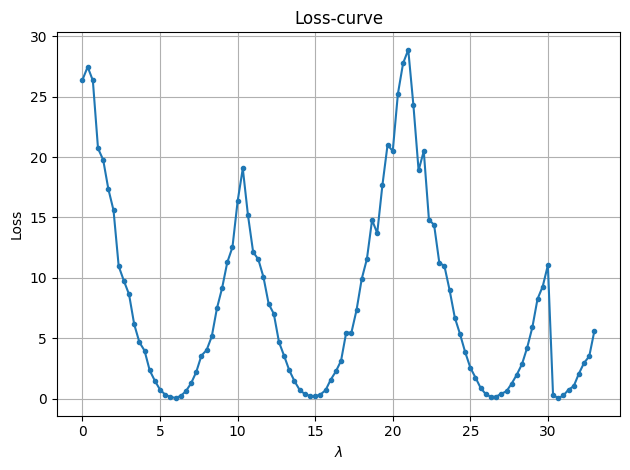

In [7]:
plt.plot(lambdas, residuals, '-o', markersize=3)
plt.xlabel(r"$E$")
plt.ylabel("Loss")
plt.title("Loss-curve")
plt.grid(True)
plt.tight_layout()
plt.show()

<font color='blue'>**Eigenvalue Refinement**</font>

After the initial sweep over $E$, a refinement step is performed to improve the approximation of the true eigenvalues. We identify local minima in the residual curve that fall below a given threshold (0.3 for instance), indicating promising candidates.

For each such candidate $E_i$, we use the associated trained model and apply scalar minimization of the residual function in a small neighborhood around $E_i$, using `minimize_scalar`. The refined eigenvalue and its residual are then stored.


In [22]:
refined_eigenvalues = []
indices = []
threshold = 3e-1

for i in range(1, len(residuals) - 1):
    if residuals[i] < residuals[i - 1] and residuals[i] < residuals[i + 1] and residuals[i] < threshold:
        E_init, model = lambdas[i], trained_models[i]

        def objective(E_val):
            xy = sample_points(1024)
            V = V1(xy).detach()
            _, res, _ = loss_fn(model, xy, E_val, V, mu=0.0)
            return res

        result = minimize_scalar(
            objective,
            bounds=(lambdas[i - 1], lambdas[i + 1]),
            method='bounded'
        )
        refined_eigenvalues.append((result.x, result.fun))
        indices.append(i)

print("-- Refined eigenvalues found ---")
for idx, (lam, res) in enumerate(refined_eigenvalues, 1):
    print(f"{idx:2d}. E ≈ {lam:.6f}   Residual ≈ {res:.2e}")

-- Refined eigenvalues found ---
 1. λ ≈ 5.878241   Residual ≈ 3.66e-02
 2. λ ≈ 14.824045   Residual ≈ 1.92e-01
 3. λ ≈ 26.569401   Residual ≈ 8.85e-02
 4. λ ≈ 30.590370   Residual ≈ 9.01e-02


<font color='blue'>**Plotting  $\Lambda(E)$ and $\bar\Lambda(E)$**</font>

The loss curve $\bar \Lambda(E)$ compared with the theoretical upper bound $\Lambda(E)$ in the interval $[E_*,E^*]$.

Since the exact eigenvalues are unknown, we construct the curve $\bar \Lambda(E)$ using the local minima stored in ´refined_eigenvalues´.

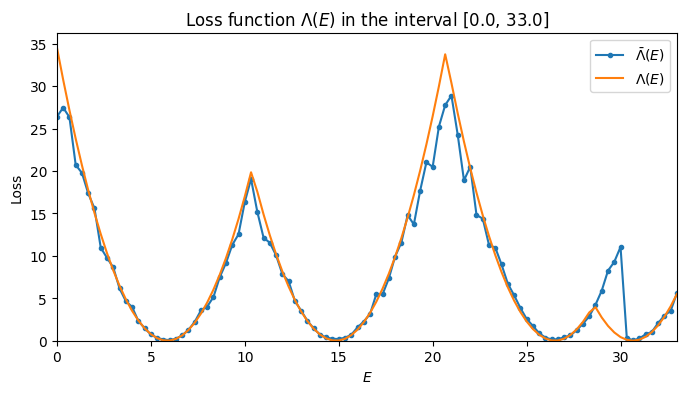

In [18]:
# Inverval [E_*, E^*]
E_min, E_max, E_step = 0.0, 33.0, 100
t = np.linspace(E_min, E_max, E_step)

# Theoretical upper bound
L = np.minimum.reduce([
    (t - refined_eigenvalues[0][0])**2,
    (t - refined_eigenvalues[1][0])**2,
    (t - refined_eigenvalues[2][0])**2,
    (t - refined_eigenvalues[3][0])**2
])

plt.figure(figsize=(8, 4))
plt.plot(lambdas, residuals, '-o', markersize=3, label=r'$\bar\Lambda(E)$')
plt.plot(t, L, label=r'$\Lambda(E)$')
plt.xlabel(r'$E$')
plt.ylabel(r'Loss')
plt.title(f'Loss function $\Lambda(E)$ in the interval [{E_min}, {E_max}]')
plt.grid(False)
plt.legend()
plt.xlim(0, 33)
plt.ylim(bottom=0)
plt.show()

<font color='blue'>**Plot of approximating eigenfunctions**</font>

\textbf{Function: \texttt{plot\_solution}}

The function **`plot_solution`** visualizes the eigenfunction $u(x, y)$ predicted by the neural network over theunit disk.

- We generate 2D grid is created over \([ -R, R ]^2\), and points outside the disk are excluded.
- The model is evaluated at interior points without gradient tracking.
- The result is displayed using a 2D contour plot of $u(x, y)$ and a 3D surface plot over the disk.
  


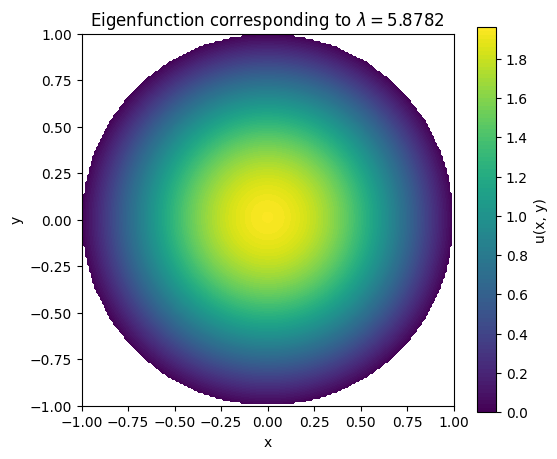

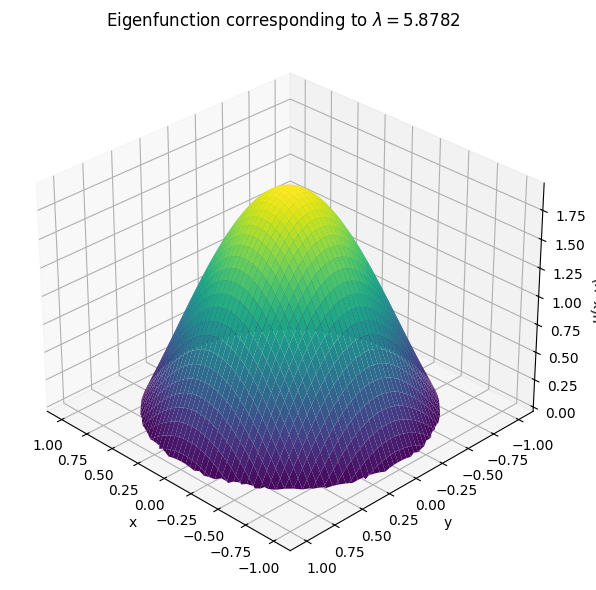

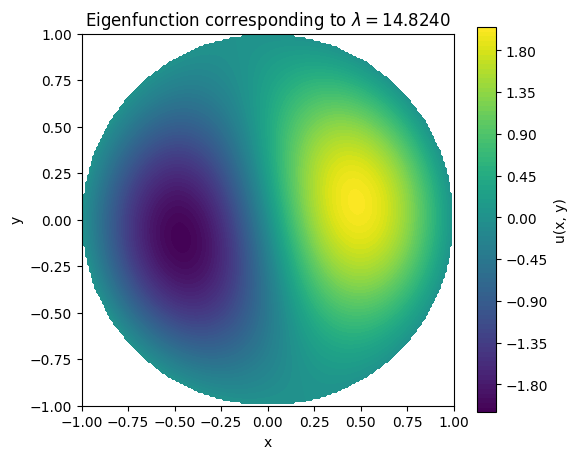

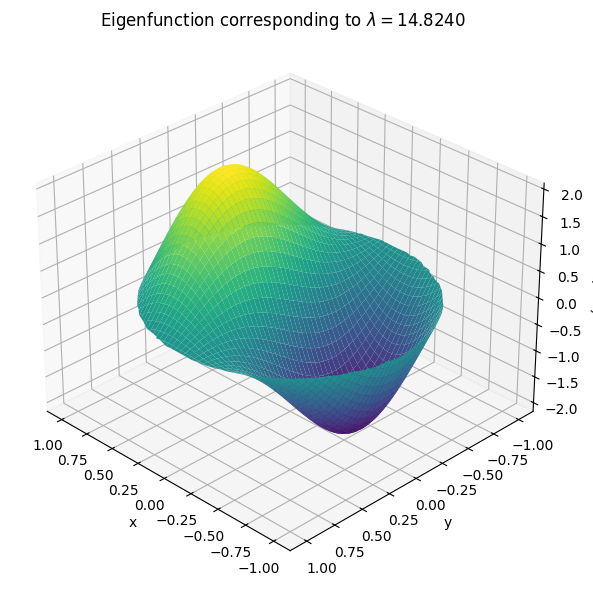

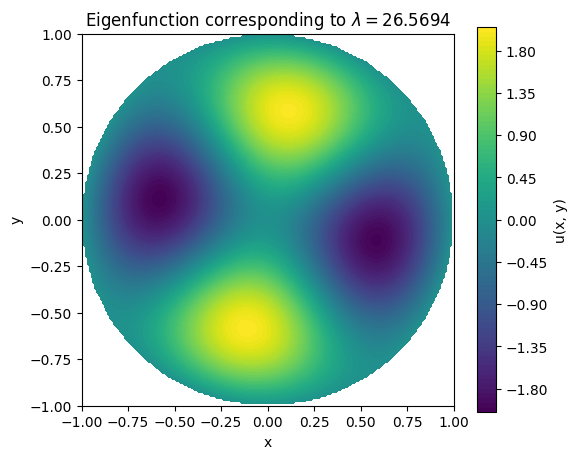

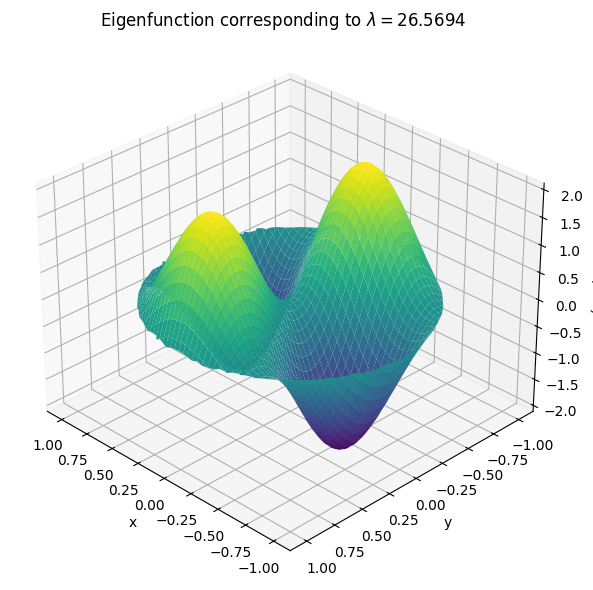

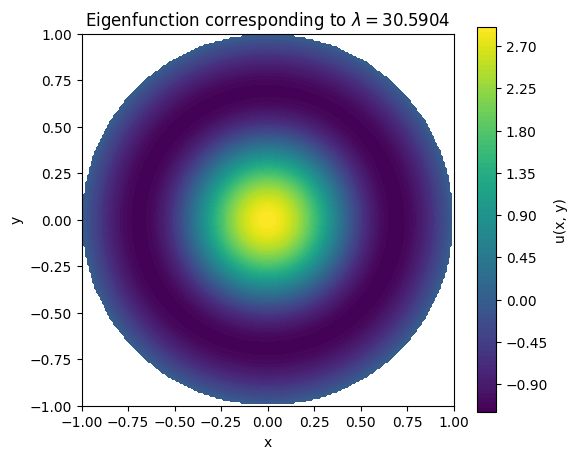

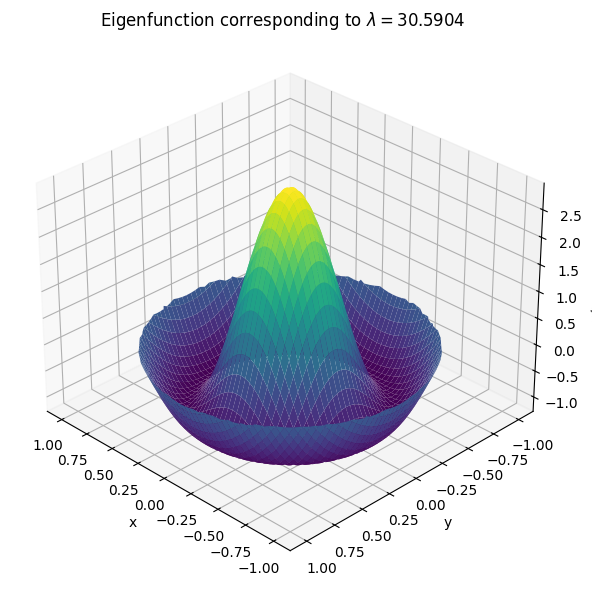

In [24]:
from mpl_toolkits.mplot3d import Axes3D

def plot_solution(model, grid_size=200, radius=1.0, E_val=0):
    # Grid for the unit disk
    x,y  = torch.linspace(-radius, radius, grid_size), torch.linspace(-radius, radius, grid_size)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
    mask = (XY[:, 0]**2 + XY[:, 1]**2 <= radius**2)
    XY_inside = XY[mask]

    # Evaluate the model on the disk
    with torch.no_grad():
        u_pred = model(XY_inside).squeeze().cpu().numpy()

    # Matrix for a full visualization
    U_plot = np.full(X.shape, np.nan)
    indices_inside = mask.nonzero().squeeze()
    U_plot_flat = U_plot.flatten()
    U_plot_flat[indices_inside] = u_pred
    U_plot = U_plot_flat.reshape(X.shape)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, U_plot, levels=100, cmap='viridis')
    plt.colorbar(label='u(x, y)')
    plt.title(fr"Eigenfunction corresponding to $E={E_val:.4f}$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.show()

    # Initialize Z with NaN and fill in the predicted values
    Z = np.full(X.shape, np.nan)
    indices_inside = mask.nonzero().squeeze()
    Z_flat = Z.flatten()
    Z_flat[indices_inside] = u_pred
    Z = Z_flat.reshape(X.shape)

    # Surface plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), Z, cmap='viridis', edgecolor='none')
    ax.set_title(fr"Eigenfunction corresponding to $E = {E_val:.4f}$")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x, y)')
    ax.view_init(elev=30, azim=135)
    plt.tight_layout()
    plt.show()

# Now, we plot the estimated eigenfunctions
for i in range(0, len(indices)):
  lam_init = refined_eigenvalues[i][0]
  model = trained_models[indices[i]]
  plot_solution(model, E_val=lam_init)

<font color='red'> **Example 2: zero potential in the unit square** </font>

Now, we consider the eigenvalue problem on the unit square in $\mathbb{R}^2$,
<font color='green'>
$$
\Omega = [0,1]\times [0,1],
$$
</font>
with the zero potential
<font color='green'>
$$
V(x,y) = 0.
$$
</font>
That is, the eigenvalue problem for the Laplacian in the unir square:
<font color='blue'>
$$
\begin{cases}
- \Delta u = E u & \text{in } \Omega, \\
u = 0 & \text{on } \partial \Omega.
\end{cases}
$$
</font>


<font color='blue'>**Neuronal network**</font>


In this case, we only need to redefine the  `forward` method to adapt the model to the unit square domain.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

class EigenFunctionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            nn.init.zeros_(m.bias)

    def forward(self, xy):
        x, y = xy[:, 0:1], xy[:, 1:2]
        u = self.net(xy)
        return x * (1 - x) * y * (1 - y) * u

<font color='blue'>**Sample and loss functions**</font>

We define the corresponding sampling function on the unit disk. The loss function remains the same but without the potential term.

In [4]:
# ---------- Sampling ----------
def sample_points(n):
    x = torch.rand(n, 1)
    y = torch.rand(n, 1)
    return torch.cat([x, y], dim=1)

# ---------- Loss function ----------
def loss_fn(model, xy, E_val, V, mu=100.0):
    xy.requires_grad_(True)
    u = model(xy)
    grad_u = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    laplace_u = sum([
        torch.autograd.grad(grad_u[:, i:i+1], xy, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, i:i+1]
        for i in range(2)
    ])
    residual = laplace_u + E_val * u
    loss_residual = (residual**2).mean()
    loss_norm = ((u**2).mean() - 1)**2
    return loss_residual + mu * loss_norm, loss_residual.item(), loss_norm.item()

<font color='blue'>**Training function**</font>

The training function is exaclty the same than before.

In [5]:
def train(model, E_val, V_tensor, n_epochs=2000, lr=1e-3, mu=100.0, early_stopping_patience=300, tol=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):
        xy = sample_points(512)
        V = V_tensor(xy).detach()
        optimizer.zero_grad()
        loss, res, norm = loss_fn(model, xy, E_val, V, mu)
        loss.backward()
        optimizer.step()
        if loss.item() < best_loss - tol:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
        if counter > early_stopping_patience:
            break
    return res, norm

def V1(xy, omega=1.0):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return 0 * omega**2 * (x**2 + y**2)

In this particular case, the exact value of the sequence of eigenvalues is known. Here the first of them:
$$
\begin{array}{|c|c|c|c|}
\hline
m & n & E_{m,n} = \pi^2(m^2 + n^2) & \text{approximation} \\
\hline
1 & 1 & 2\pi^2 & \approx 19.739 \\
2 & 1 & 5\pi^2 & \approx 49.348 \\
1 & 2 & 5\pi^2 & \approx 49.348 \\
2 & 2 & 8\pi^2 & \approx 78.956 \\
3 & 1 & 10\pi^2 & \approx 98.696 \\
1 & 3 & 10\pi^2 & \approx 98.696 \\
3 & 2 & 13\pi^2 & \approx 128.305 \\
\hline
\end{array}
$$

<font color='blue'>**Main loop**</font>

Then, as before, we train the neural network over a range of eigenvalues $E \in [E_*, E^*]$ sampled at a fixed number of points. For each $E$, the model approximates the corresponding eigenfunction.

In [7]:
E_min, E_max, E_step = 0.0, 85.0, 80
lambdas = np.linspace(E_min, E_max, E_step)
residuals, trained_models = [], []

model = EigenFunctionNN()
for i, lam in enumerate(lambdas):
    if i > 0 and i % 50 !=0:
        new_model = EigenFunctionNN()
        new_model.load_state_dict(model.state_dict())
        model = new_model
    else:
        model = EigenFunctionNN()
    res, norm_err = train(model, E_val=lam, V_tensor=V1, mu=450 )
    print(f"E={lam:.2f} -> residual={res:.4e}, norm_err={norm_err:.2e}")

    residuals.append(res)
    trained_models.append(model)

E=0.00 -> residual=2.1952e+02, norm_err=1.92e-01
E=1.08 -> residual=2.0304e+02, norm_err=1.75e-01
E=2.15 -> residual=2.1122e+02, norm_err=1.00e-01
E=3.23 -> residual=1.6680e+02, norm_err=1.51e-01
E=4.30 -> residual=1.5691e+02, norm_err=1.18e-01
E=5.38 -> residual=1.6383e+02, norm_err=4.32e-02
E=6.46 -> residual=1.4496e+02, norm_err=3.13e-02
E=7.53 -> residual=1.4121e+02, norm_err=2.97e-03
E=8.61 -> residual=9.9842e+01, norm_err=3.77e-02
E=9.68 -> residual=8.9205e+01, norm_err=1.56e-02
E=10.76 -> residual=6.8946e+01, norm_err=2.20e-02
E=11.84 -> residual=5.7527e+01, norm_err=7.55e-03
E=12.91 -> residual=4.6244e+01, norm_err=1.09e-04
E=13.99 -> residual=3.2854e+01, norm_err=5.23e-05
E=15.06 -> residual=2.0495e+01, norm_err=6.22e-03
E=16.14 -> residual=1.3708e+01, norm_err=2.42e-03
E=17.22 -> residual=6.7699e+00, norm_err=2.65e-03
E=18.29 -> residual=2.5276e+00, norm_err=1.55e-05
E=19.37 -> residual=1.7077e-01, norm_err=8.07e-05
E=20.44 -> residual=6.1578e-01, norm_err=2.86e-04
E=21.52 ->

<font color='blue'>**Plot of residuals vs E's**</font>


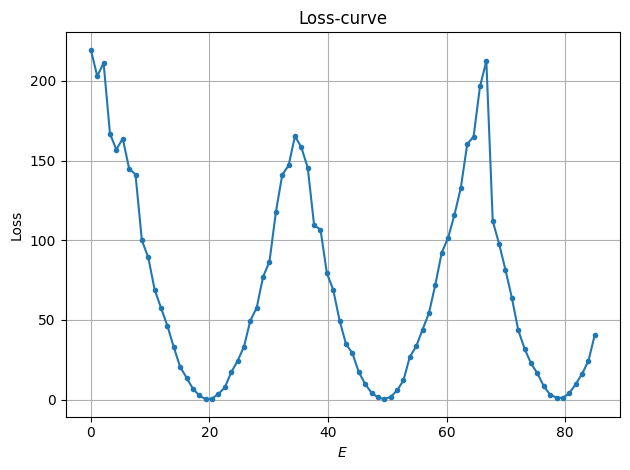

In [8]:
plt.plot(lambdas, residuals, '-o', markersize=3)
plt.xlabel(r"$E$")
plt.ylabel("Loss")
plt.title("Loss-curve")
plt.grid(True)
plt.tight_layout()
plt.show()

<font color='blue'>**Eigenvalue Refinement**</font>

After the initial sweep over $E$, a refinement step is performed to improve the approximation of the true eigenvalues.

In [12]:
refined_eigenvalues = []
indices = []
threshold = 2

for i in range(1, len(residuals) - 1):
    if residuals[i] < residuals[i - 1] and residuals[i] < residuals[i + 1] and residuals[i] < threshold:
        E_init, model = lambdas[i], trained_models[i]

        def objective(E_val):
            xy = sample_points(1024)
            V = V1(xy).detach()
            _, res, _ = loss_fn(model, xy, E_val, V, mu=0.0)
            return res

        result = minimize_scalar(
            objective,
            bounds=(lambdas[i - 1], lambdas[i + 1]),
            method='bounded'
        )
        refined_eigenvalues.append((result.x, result.fun))
        indices.append(i)

print("-- Refined eigenvalues found ---")
for idx, (lam, res) in enumerate(refined_eigenvalues, 1):
    print(f"{idx:2d}. E ≈ {lam:.6f}   Residual ≈ {res:.2e}")

-- Refined eigenvalues found ---
 1. λ ≈ 19.746899   Residual ≈ 4.35e-02
 2. λ ≈ 49.352123   Residual ≈ 2.24e-01
 3. λ ≈ 79.150463   Residual ≈ 9.13e-01


<font color='blue'>**Plotting  $\Lambda(E)$ and $\bar\Lambda(E)$**</font>

The loss curve $\bar \Lambda(E)$ compared with the theoretical upper bound $\Lambda(E)$ in the interval $[E_*,E^*]$. To define the theoretical curve we use the exact values of eigenvalues.

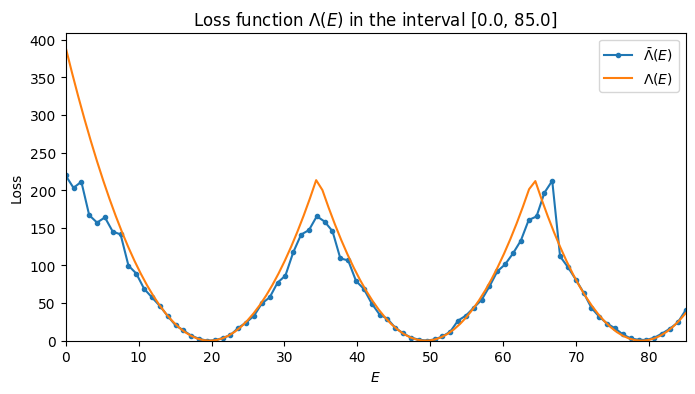

In [15]:
# Inverval [E_*, E^*]
E_min, E_max, E_step = 0.0, 85.0, 100
t = np.linspace(E_min, E_max, E_step)

# Theoretical upper bound
L = np.minimum.reduce([
    (t - 19.739)**2,
    (t - 49.348)**2,
    (t - 78.956)**2,
    (t - 98.696)**2,
    (t - 128.305)**2
])

plt.figure(figsize=(8, 4))
plt.plot(lambdas, residuals, '-o', markersize=3, label=r'$\bar\Lambda(E)$')
plt.plot(t, L, label=r'$\Lambda(E)$')
plt.xlabel(r'$E$')
plt.ylabel(r'Loss')
plt.title(f'Loss function $\Lambda(E)$ in the interval [{E_min}, {E_max}]')
plt.grid(False)
plt.legend()
plt.xlim(0, 85)
plt.ylim(bottom=0)
plt.show()

<font color='blue'>**Plot of approximating eigenfunctions**</font>

The function **`plot_solution`** visualizes the eigenfunction $u(x, y)$ predicted by the neural network over the unit square.

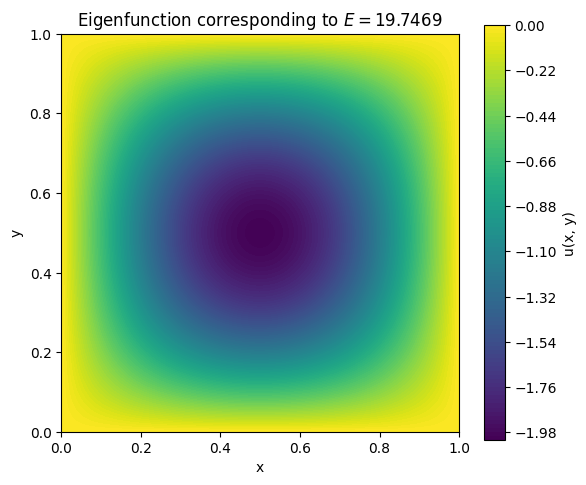

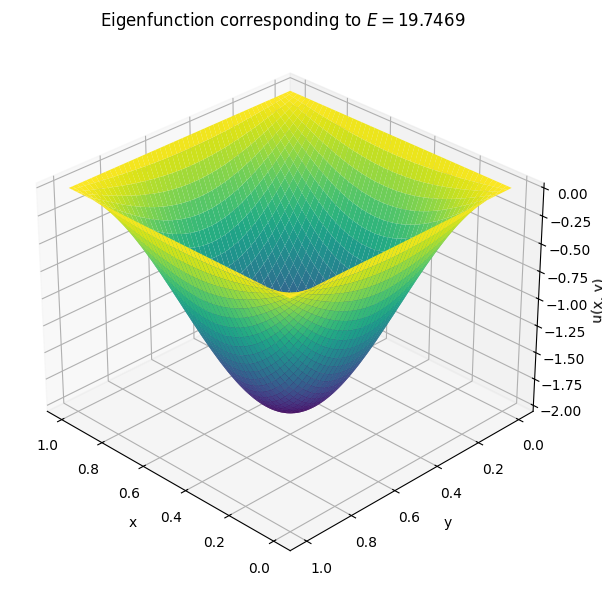

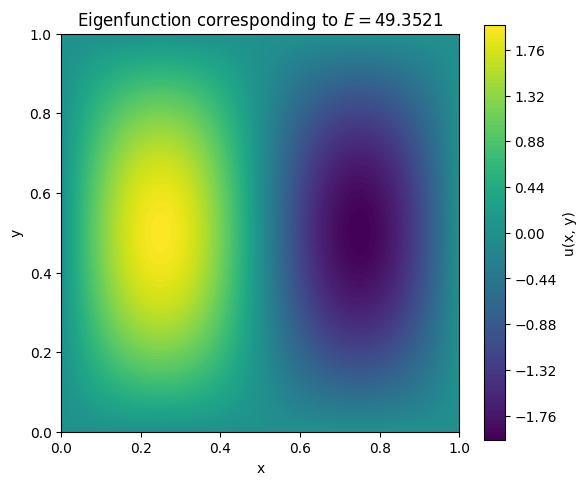

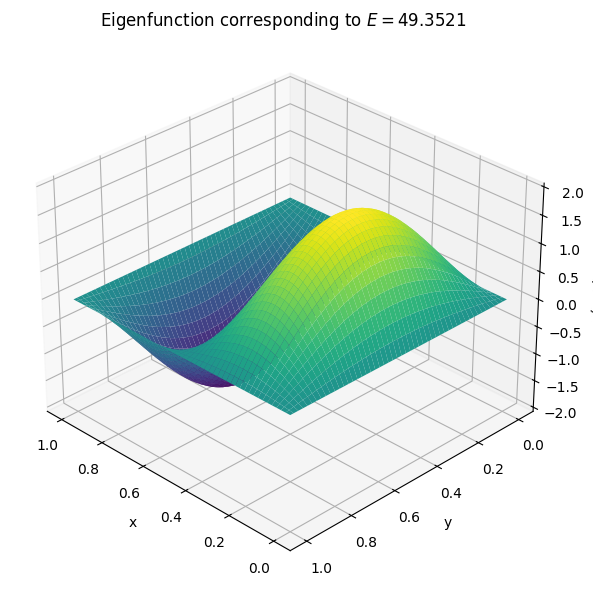

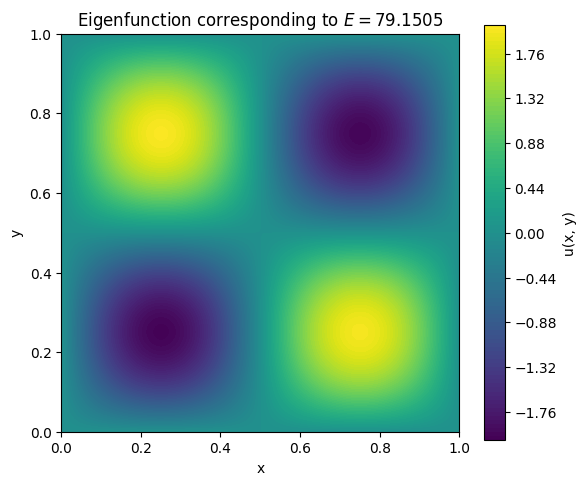

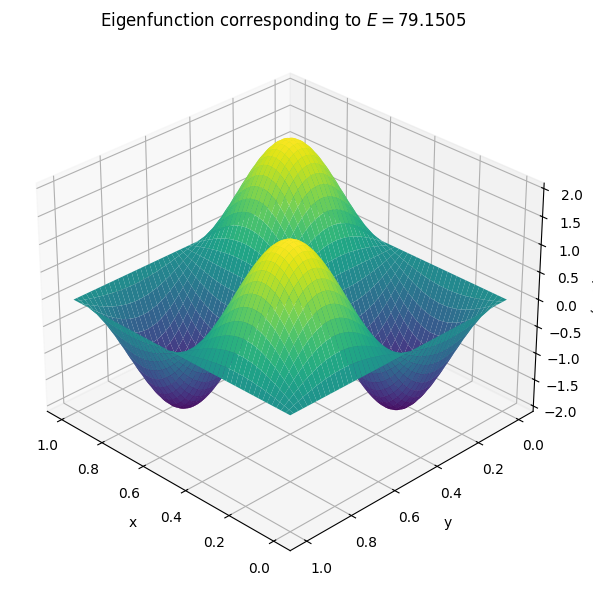

In [19]:
from mpl_toolkits.mplot3d import Axes3D

def plot_solution(model, grid_size=200, E_val=0):
    x,y  = torch.linspace(0, 1, grid_size), torch.linspace(0, 1, grid_size)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)

    # Evaluate in the domain
    with torch.no_grad():
        u_pred = model(XY).squeeze().cpu().numpy()

    # Matrix for a full visualization
    U_plot = u_pred.reshape(grid_size, grid_size)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, U_plot, levels=100, cmap='viridis')
    plt.colorbar(label='u(x, y)')
    plt.title(f"Eigenfunction corresponding to $E ={E_val:.4f}$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # Surface plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), U_plot, cmap='viridis', edgecolor='none')
    ax.set_title(f"Eigenfunction corresponding to $E = {E_val:.4f}$")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x, y)')
    ax.view_init(elev=30, azim=135)
    plt.tight_layout()
    plt.show()

# Now, we plot the estimated eigenfunctions
for i in range(0, len(indices)):
  lam_init = refined_eigenvalues[i][0]
  model = trained_models[indices[i]]
  plot_solution(model, E_val=lam_init)

<font color='red'> **Example 3: p-Laplacian with a potential in the unit disk** </font>

The p-Laplacian operator of a function $u$ is defined as
<font color='green'>
$$
\Delta_p u := \nabla \cdot(|\nabla u|^{p-2}\nabla u).
$$
</font>

With a minor modification of the code we can deal with the eigenvalue problem for the p-Laplacian given by
<font color='blue'>
$$
\begin{cases}
- \Delta_p u + V(x) |u|^{p-2}u = E |u|^{p-2}u & \text{in } \Omega, \\
u = 0 & \text{on } \partial \Omega,
\end{cases}
$$
</font>
where <font color='green'>$V : \mathbb{R}^n \to \mathbb{R}$ </font>is a given potential function and <font color='green'>$E$</font> is the eigenvalue parameter. Here $\Omega$ is the unit ball in $\mathbb{R}^2$ and for simplicity we take the potential $V=0$. In this example we take <font color='green'>$p=2.2$</font>.

<font color='blue'>**Neuronal network**</font>


In this case, we only need to redefine the  `forward` method to adapt the model to the unit disk.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# the value of p
p=2.2

class EigenFunctionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            nn.init.zeros_(m.bias)

    def forward(self, xy):
        x, y = xy[:, 0:1], xy[:, 1:2]
        u = self.net(xy)
        return (1 - x**2 - y**2) * u

<font color='blue'>**Potential function**</font>

In [36]:
def V1(xy, omega=1.0):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return 0 * omega**2 * (x**2 + y**2)

<font color='blue'>**Sample function**</font>

As before , te function **sample_points(n)** generates $n$ points uniformly distributed inside the unit disk.

In [37]:
def sample_points(n):
    r = torch.sqrt(torch.rand(n, 1))
    theta = 2 * np.pi * torch.rand(n, 1)
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    return torch.cat([x, y], dim=1)

<font color='blue'>**Loss function**</font>

The function **`loss_fn`** computes the loss used to train the neural network to approximate eigenfunctions of the eigenvalue problem, that is,
$$
\bar  \Lambda(u,E)=\int_\Omega (\Delta_p u - V|u|^{p-2}u + E|u|^{p-2}u)^2\,dx + \mu\left(\int_\Omega |u|^p\,dx-1\right)^2.
$$
The only difference with the case of the Laplacian is that we add the input parameter `p` corresponding to the p-Laplacian.


In [38]:
def loss_fn(p, model, xy, E_val, V,  mu=100.0):
    xy.requires_grad_(True)
    u = model(xy)

    grad_u = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # shape [N,d]
    grad_u_norm = torch.norm(grad_u, dim=1, keepdim=True) + 1e-12  # evitar división por cero

    # Vector para el cálculo de la divergencia
    A = (grad_u_norm ** (p - 2)) * grad_u  # [N,d]

    div = 0
    for i in range(xy.shape[1]):  # dimensión d
        grad_Ai = torch.autograd.grad(
            A[:, i].sum(), xy, create_graph=True)[0][:, i:i+1]  # derivada parcial respecto a x_i
        div = div + grad_Ai

    residual = div - V * u + E_val * u

    loss_residual = (residual ** 2).mean()
    loss_norm = ((u ** 2).mean() - 1) ** 2

    return loss_residual + mu * loss_norm, loss_residual.item(), loss_norm.item()

<font color='blue'>**Training function**</font>

The function **`train`** performs the optimization of the neural network to approximate an eigenfunction of the operator $-\Delta_p + V(x)$, associated with a given eigenvalue $E$. We use the same than for the Laplacian.

In [39]:
def train(p, model, E_val, V_tensor, n_epochs=2000, lr=1e-3, mu=100.0, early_stopping_patience=300, tol=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):
        xy = sample_points(1000)
        V = V_tensor(xy).detach()
        optimizer.zero_grad()
        loss, res, norm = loss_fn(p,model, xy, E_val, V, mu)
        loss.backward()
        optimizer.step()
        if loss.item() < best_loss - tol:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
        if counter > early_stopping_patience:
            break
    return res, norm

<font color='blue'>**Main loop**</font>

We train the neural network over a range of eigenvalues $E \in [E_*, E^*]$ sampled at a fixed number of points. For each $E$, the model approximates the corresponding eigenfunction under the potential $V$.

Additionally, we introduce a variable expression for the parameter $\mu$ to highlight the role of the normalization term. In this example, we set $\mu = 150 + \lambda^2$.

In [41]:
E_min, E_max, E_step = 0.0, 45.0, 100
lambdas = np.linspace(E_min, E_max, E_step)
residuals, trained_models = [], []

model = EigenFunctionNN()
for i, lam in enumerate(lambdas):
    if i > 0 and i % 25 !=0:
        new_model = EigenFunctionNN()
        new_model.load_state_dict(model.state_dict())
        model = new_model
    else:
        model = EigenFunctionNN()
    res, norm_err = train(p, model, E_val=lam, V_tensor=V1, mu=150 + lam*lam)
    print(f"E={lam:.2f} -> residual={res:.4e}, norm_err={norm_err:.2e}")
    residuals.append(res)
    trained_models.append(model)

E=0.00 -> residual=3.8039e+01, norm_err=3.31e-02
E=0.45 -> residual=3.4688e+01, norm_err=2.27e-02
E=0.91 -> residual=3.2840e+01, norm_err=6.70e-03
E=1.36 -> residual=2.7784e+01, norm_err=8.54e-03
E=1.82 -> residual=2.3711e+01, norm_err=5.42e-03
E=2.27 -> residual=1.8451e+01, norm_err=1.57e-02
E=2.73 -> residual=1.6793e+01, norm_err=1.44e-03
E=3.18 -> residual=1.3926e+01, norm_err=2.28e-04
E=3.64 -> residual=9.4061e+00, norm_err=9.98e-03
E=4.09 -> residual=8.5964e+00, norm_err=2.79e-04
E=4.55 -> residual=5.8622e+00, norm_err=2.60e-04
E=5.00 -> residual=3.7181e+00, norm_err=2.86e-04
E=5.45 -> residual=2.1293e+00, norm_err=2.03e-03
E=5.91 -> residual=1.0055e+00, norm_err=1.53e-03
E=6.36 -> residual=4.4747e-01, norm_err=2.40e-03
E=6.82 -> residual=1.2735e-01, norm_err=9.52e-03
E=7.27 -> residual=1.9794e-01, norm_err=2.80e-03
E=7.73 -> residual=6.5015e-01, norm_err=1.40e-03
E=8.18 -> residual=1.5817e+00, norm_err=8.56e-04
E=8.64 -> residual=2.8980e+00, norm_err=7.04e-04
E=9.09 -> residual=4

<font color='blue'>**Plot of residuals vs E's**</font>

We plot the loss values computed for different values of $E$.

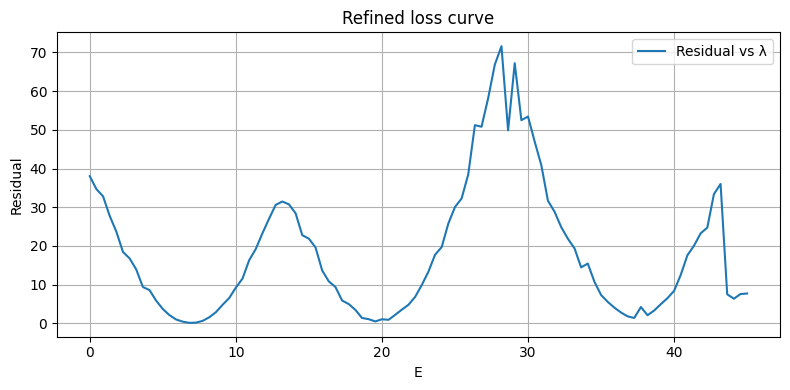

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(lambdas, residuals, label="Residual vs λ")
plt.xlabel("E")
plt.ylabel("Residual")
plt.title("Refined loss curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<font color='blue'>**Eigenvalue Refinement**</font>

After the initial sweep over $E$, a refinement step is performed to improve the approximation of the true eigenvalues.

In [64]:
refined_eigenvalues = []
indices = []
threshold = 0.7

for i in range(1, len(residuals) - 1):
    if residuals[i] < residuals[i - 1] and residuals[i] < residuals[i + 1] and residuals[i] < threshold:
        E_init, model = lambdas[i], trained_models[i]

        def objective(E_val):
            xy = sample_points(1024)
            V = V1(xy).detach()
            _, res, _ = loss_fn(p, model, xy, E_val, V, mu=0.0)
            return res

        result = minimize_scalar(
            objective,
            bounds=(lambdas[i - 1], lambdas[i + 1]),
            method='bounded'
        )
        refined_eigenvalues.append((result.x, result.fun))
        indices.append(i)


print("-- Refined eigenvalues found ---")
for idx, (lam, res) in enumerate(refined_eigenvalues, 1):
    print(f"{idx:2d}. E ≈ {lam:.6f}   Residual ≈ {res:.2e}")




-- Refined eigenvalues found ---
 1. E ≈ 7.053818   Residual ≈ 9.08e-02
 2. E ≈ 19.712152   Residual ≈ 2.47e-01


<font color='blue'>**Plotting  $\Lambda(E)$ and $\bar\Lambda(E)$**</font>

The loss curve $\bar \Lambda(E)$ compared with the theoretical upper bound $\Lambda(E)$ in the interval $[E_*,E^*]$.

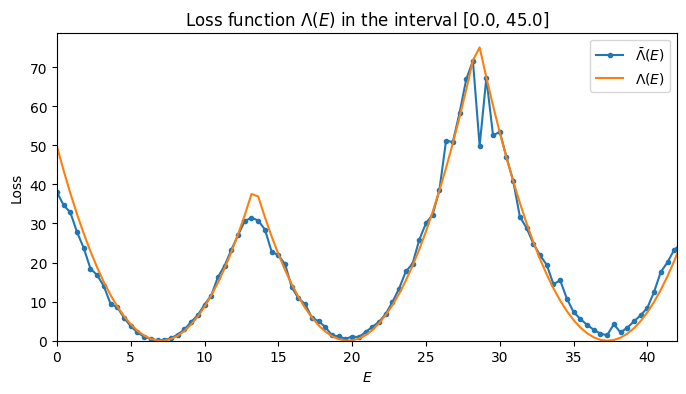

In [69]:
# Inverval [E_*, E^*]
E_min, E_max, E_step = 0.0, 45.0, 100
t = np.linspace(E_min, E_max, E_step)

# Theoretical upper bound
L = np.minimum.reduce([
    (t - refined_eigenvalues[0][0])**2,
    (t - refined_eigenvalues[1][0])**2,
    (t - 37.3)**2
])

plt.figure(figsize=(8, 4))
plt.plot(lambdas, residuals, '-o', markersize=3, label=r'$\bar\Lambda(E)$')
plt.plot(t, L, label=r'$\Lambda(E)$')
plt.xlabel(r'$E$')
plt.ylabel(r'Loss')
plt.title(f'Loss function $\Lambda(E)$ in the interval [{E_min}, {E_max}]')
plt.grid(False)
plt.legend()
plt.xlim(0, 42)
plt.ylim(bottom=0)
plt.show()

<font color='blue'>**Plot of approximating eigenfunctions**</font>

\textbf{Function: \texttt{plot\_solution}}

The function **`plot_solution`** visualizes the eigenfunction $u(x, y)$ predicted by the neural network over theunit square.

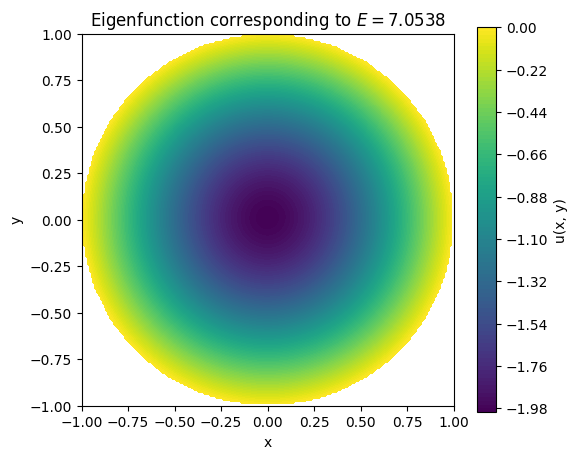

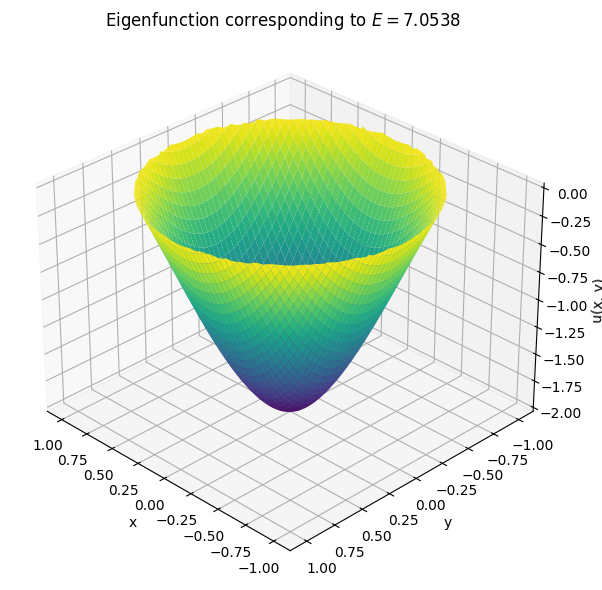

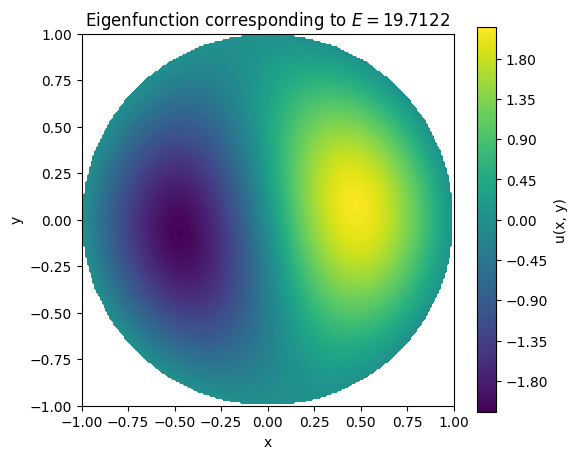

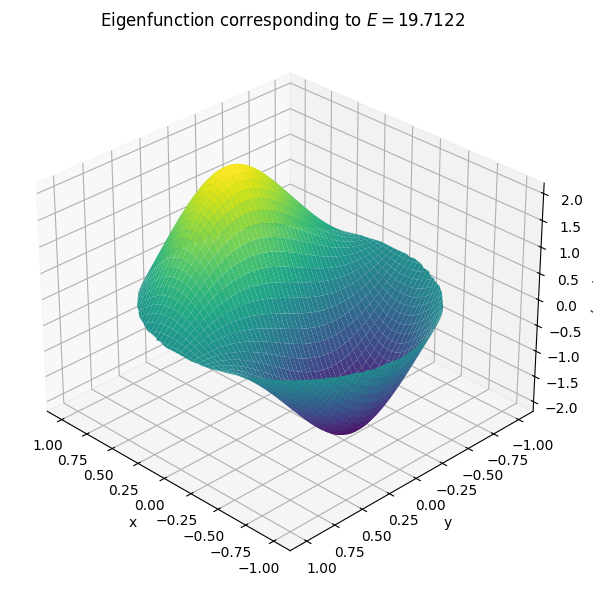

In [70]:
from mpl_toolkits.mplot3d import Axes3D

def plot_solution(model, grid_size=200, radius=1.0, E_val=0):
    # Grid for the unit disk
    x,y  = torch.linspace(-radius, radius, grid_size), torch.linspace(-radius, radius, grid_size)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
    mask = (XY[:, 0]**2 + XY[:, 1]**2 <= radius**2)
    XY_inside = XY[mask]

    # Evaluate the model on the disk
    with torch.no_grad():
        u_pred = model(XY_inside).squeeze().cpu().numpy()

    # Matrix for a full visualization
    U_plot = np.full(X.shape, np.nan)
    indices_inside = mask.nonzero().squeeze()
    U_plot_flat = U_plot.flatten()
    U_plot_flat[indices_inside] = u_pred
    U_plot = U_plot_flat.reshape(X.shape)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, U_plot, levels=100, cmap='viridis')
    plt.colorbar(label='u(x, y)')
    plt.title(fr"Eigenfunction corresponding to $E={E_val:.4f}$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.show()

    # Initialize Z with NaN and fill in the predicted values
    Z = np.full(X.shape, np.nan)
    indices_inside = mask.nonzero().squeeze()
    Z_flat = Z.flatten()
    Z_flat[indices_inside] = u_pred
    Z = Z_flat.reshape(X.shape)

    # Surface plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), Z, cmap='viridis', edgecolor='none')
    ax.set_title(fr"Eigenfunction corresponding to $E = {E_val:.4f}$")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x, y)')
    ax.view_init(elev=30, azim=135)
    plt.tight_layout()
    plt.show()

# Now, we plot the estimated eigenfunctions
for i in range(0, len(indices)):
  lam_init = refined_eigenvalues[i][0]
  model = trained_models[indices[i]]
  plot_solution(model, E_val=lam_init)

<font color='red'> **Example 4: Laplacian with a potential in a triangular domain** </font>

We consider the foloowing eigenvalue problem with Dirichlet boundary conditions
<font color='blue'>
$$
\begin{cases}
- \Delta u + V(x) u = E u & \text{in } \Omega, \\
u = 0 & \text{on } \partial \Omega,
\end{cases}
$$
</font>
where <font color='green'>$V : \mathbb{R}^n \to \mathbb{R}$ </font>is a given potential function and <font color='green'>$\Omega$</font> is the planar triangle with vertices $(0,0)$, $(0,1)$, $(1,0)$.

<font color='blue'>**Neuronal network**</font>


In this case, we only need to redefine the  `forward` method to adapt the model to the triangular domain.

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

class EigenFunctionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            nn.init.zeros_(m.bias)

    def forward(self, xy):
        x, y = xy[:, 0:1], xy[:, 1:2]
        u = self.net(xy)
        return x * y * (1 - x - y) * u

<font color='blue'>**Sample and loss functions**</font>

We define the corresponding sampling function on the triangular domain. The loss function remains the same but without the potential term.

In [77]:
# ---------- Potential function ----------
def V1(xy, omega=1.0):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return 0*0.5 * omega**2 * (x**2 + y**2)

# ---------- Sampling ----------
def sample_points(n):
    u = torch.rand(n, 1)
    v = torch.rand(n, 1)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    x = u
    y = v
    return torch.cat([x, y], dim=1)

# ---------- Loss function ----------
def loss_fn(model, xy, E_val, V, mu=100.0):
    xy.requires_grad_(True)
    u = model(xy)
    grad_u = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    laplace_u = sum([
        torch.autograd.grad(grad_u[:, i:i+1], xy, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, i:i+1]
        for i in range(2)
    ])
    residual = laplace_u + E_val * u
    loss_residual = (residual**2).mean()
    loss_norm = ((u**2).mean() - 1)**2
    return loss_residual + mu * loss_norm, loss_residual.item(), loss_norm.item()

<font color='blue'>**Training function**</font>

The training function is exaclty the same than before.

In [86]:
def train(model, E_val, V_tensor, n_epochs=2000, lr=1e-3, mu=100.0, early_stopping_patience=300, tol=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):
        xy = sample_points(1012)
        V = V_tensor(xy).detach()
        optimizer.zero_grad()
        loss, res, norm = loss_fn(model, xy, E_val, V, mu)
        loss.backward()
        optimizer.step()
        if loss.item() < best_loss - tol:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
        if counter > early_stopping_patience:
            break
    return res, norm

In this particular case, the exact value of the sequence of eigenvalues is known. Here the first of them:

\begin{array}{c c c c}
\hline
m & n & E_{m,n} = \pi^2 (m^2 + n^2) &\text{Valor numérico} \\
\hline
1 & 2 & 5 \pi^2 & 49.348 \\
2 & 1 & 5 \pi^2 & 49.348 \\
1 & 3 & 10 \pi^2 & 98.696 \\
3 & 1 & 10 \pi^2 & 98.696 \\
2 & 3 & 13 \pi^2 & 128.996 \\
3 & 2 & 13 \pi^2 & 128.996 \\
1 & 4 & 17 \pi^2 & 167.551 \\
4 & 1 & 17 \pi^2 & 167.551 \\
3 & 3 & 18 \pi^2 & 177.652 \\
2 & 4 & 20 \pi^2 & 197.392 \\
4 & 2 & 20 \pi^2 & 197.392 \\
\hline
\end{array}


<font color='blue'>**Main loop**</font>

Then, as before, we train the neural network over a range of eigenvalues $E \in [E_*, E^*]$ sampled at a fixed number of points. For each $E$, the model approximates the corresponding eigenfunction.

In [88]:
E_min, E_max, E_step = 0.0, 180.0, 120
lambdas = np.linspace(E_min, E_max, E_step)
residuals, trained_models = [], []

model = EigenFunctionNN()
for i, lam in enumerate(lambdas):
    if i > 0 and i % 50 !=0:
        new_model = EigenFunctionNN()
        new_model.load_state_dict(model.state_dict())
        model = new_model
    else:
        model = EigenFunctionNN()
    res, norm_err = train(model, E_val=lam, V_tensor=V1, mu=15000 )
    print(f"E={lam:.2f} -> residual={res:.4e}, norm_err={norm_err:.2e}")

    residuals.append(res)
    trained_models.append(model)

E=0.00 -> residual=2.1639e+03, norm_err=1.34e-02
E=1.51 -> residual=2.2121e+03, norm_err=1.31e-03
E=3.03 -> residual=1.9593e+03, norm_err=9.61e-03
E=4.54 -> residual=1.8900e+03, norm_err=4.15e-03
E=6.05 -> residual=1.7168e+03, norm_err=6.92e-03
E=7.56 -> residual=1.5472e+03, norm_err=1.28e-02
E=9.08 -> residual=1.5353e+03, norm_err=2.80e-03
E=10.59 -> residual=1.4945e+03, norm_err=1.08e-04
E=12.10 -> residual=1.3686e+03, norm_err=3.02e-04
E=13.61 -> residual=1.1790e+03, norm_err=6.05e-03
E=15.13 -> residual=1.1607e+03, norm_err=1.81e-04
E=16.64 -> residual=1.0473e+03, norm_err=1.12e-03
E=18.15 -> residual=9.1545e+02, norm_err=4.66e-03
E=19.66 -> residual=8.6350e+02, norm_err=3.56e-04
E=21.18 -> residual=8.3006e+02, norm_err=1.74e-03
E=22.69 -> residual=7.1740e+02, norm_err=9.85e-06
E=24.20 -> residual=6.5490e+02, norm_err=1.07e-03
E=25.71 -> residual=5.7317e+02, norm_err=4.86e-04
E=27.23 -> residual=4.2233e+02, norm_err=1.95e-02
E=28.74 -> residual=4.2591e+02, norm_err=3.45e-07
E=30.25

<font color='blue'>**Plot of residuals vs E's**</font>


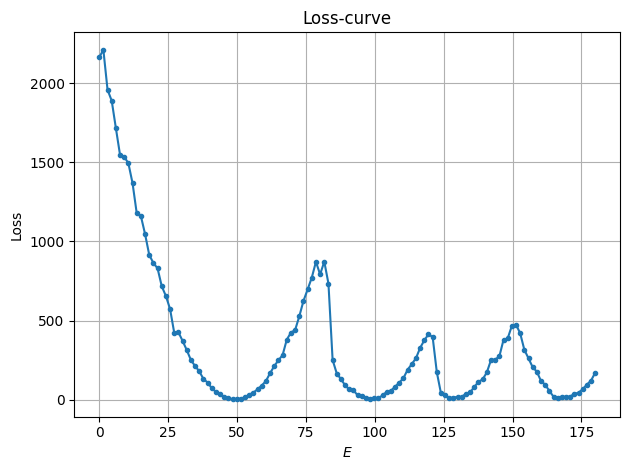

In [89]:
plt.plot(lambdas, residuals, '-o', markersize=3)
plt.xlabel(r"$E$")
plt.ylabel("Loss")
plt.title("Loss-curve")
plt.grid(True)
plt.tight_layout()
plt.show()

<font color='blue'>**Eigenvalue Refinement**</font>

After the initial sweep over $E$, a refinement step is performed to improve the approximation of the true eigenvalues.

In [97]:
refined_eigenvalues = []
indices = []
threshold = 15

for i in range(1, len(residuals) - 1):
    if residuals[i] < residuals[i - 1] and residuals[i] < residuals[i + 1] and residuals[i] < threshold:
        E_init, model = lambdas[i], trained_models[i]

        def objective(E_val):
            xy = sample_points(1024)
            V = V1(xy).detach()
            _, res, _ = loss_fn(model, xy, E_val, V, mu=0.0)
            return res

        result = minimize_scalar(
            objective,
            bounds=(lambdas[i - 1], lambdas[i + 1]),
            method='bounded'
        )
        refined_eigenvalues.append((result.x, result.fun))
        indices.append(i)

print("-- Refined eigenvalues found ---")
for idx, (lam, res) in enumerate(refined_eigenvalues, 1):
    print(f"{idx:2d}. λ ≈ {lam:.6f}   Residual ≈ {res:.2e}")

-- Refined eigenvalues found ---
 1. λ ≈ 49.353903   Residual ≈ 3.34e+00
 2. λ ≈ 98.949188   Residual ≈ 1.38e+00
 3. λ ≈ 128.079764   Residual ≈ 9.67e+00
 4. λ ≈ 167.187798   Residual ≈ 9.70e+00


<font color='blue'>**Plotting  $\Lambda(E)$ and $\bar\Lambda(E)$**</font>

The loss curve $\bar \Lambda(E)$ compared with the theoretical upper bound $\Lambda(E)$ in the interval $[E_*,E^*]$. To define the theoretical curve we use the exact values of eigenvalues.

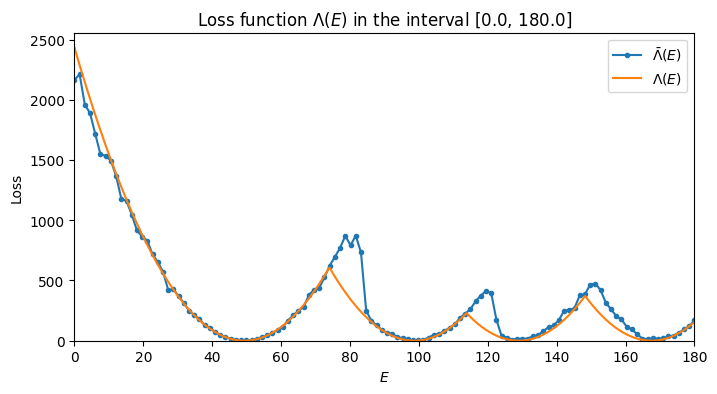

In [98]:
# Inverval [E_*, E^*]
E_min, E_max, E_step = 0.0, 180.0, 1000
t = np.linspace(E_min, E_max, E_step)

# Theoretical upper bound
L = np.minimum.reduce([
    (t - 49.348)**2,
    (t - 98.696)**2,
    (t - 128.996)**2,
    (t - 167.551)**2
])

plt.figure(figsize=(8, 4))
plt.plot(lambdas, residuals, '-o', markersize=3, label=r'$\bar\Lambda(E)$')
plt.plot(t, L, label=r'$\Lambda(E)$')
plt.xlabel(r'$E$')
plt.ylabel(r'Loss')
plt.title(f'Loss function $\Lambda(E)$ in the interval [{E_min}, {E_max}]')
plt.grid(False)
plt.legend()
plt.xlim(0, 180)
plt.ylim(bottom=0)
plt.show()

<font color='blue'>**Plot of approximating eigenfunctions**</font>

\textbf{Function: \texttt{plot\_solution}}

The function **`plot_solution`** visualizes the eigenfunction $u(x, y)$ predicted by the neural network over the triangle.

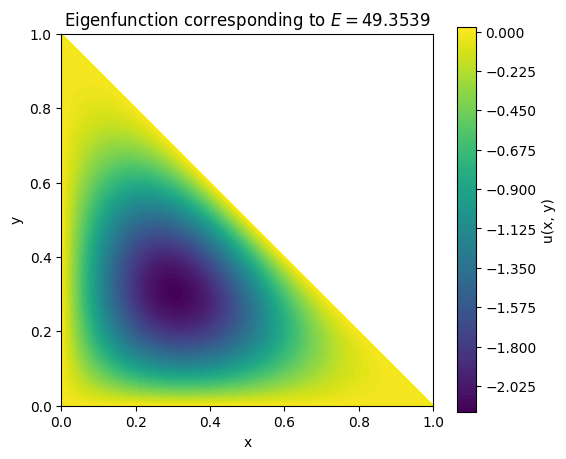

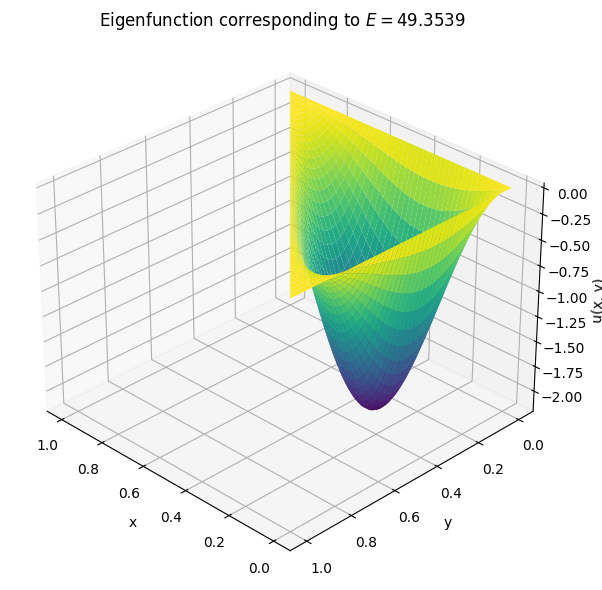

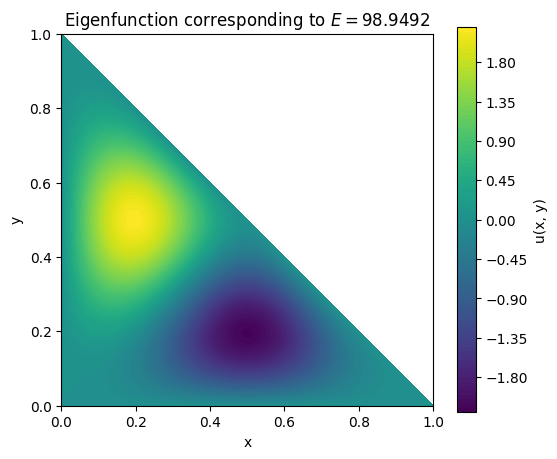

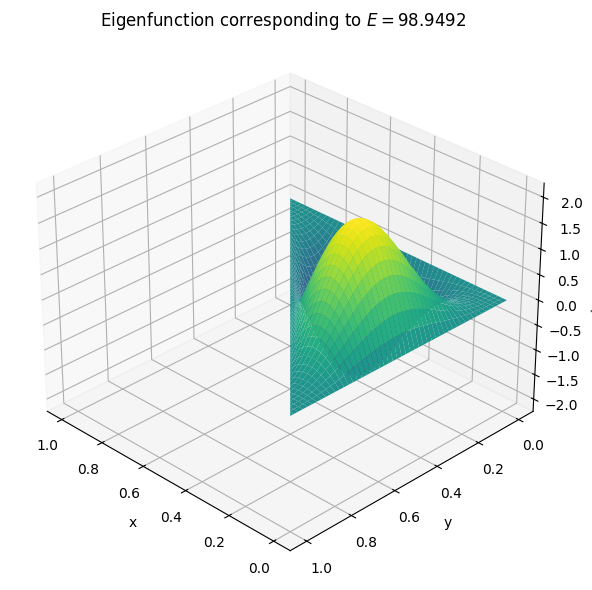

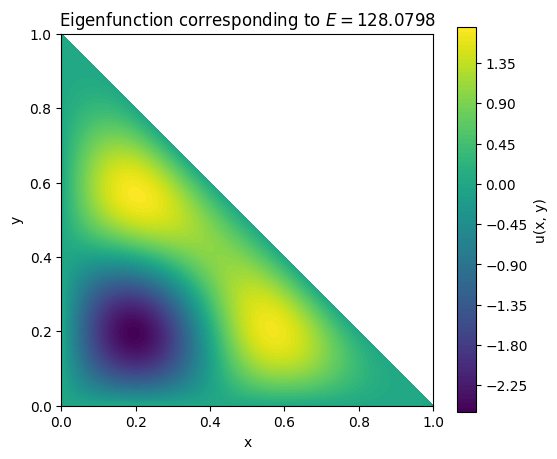

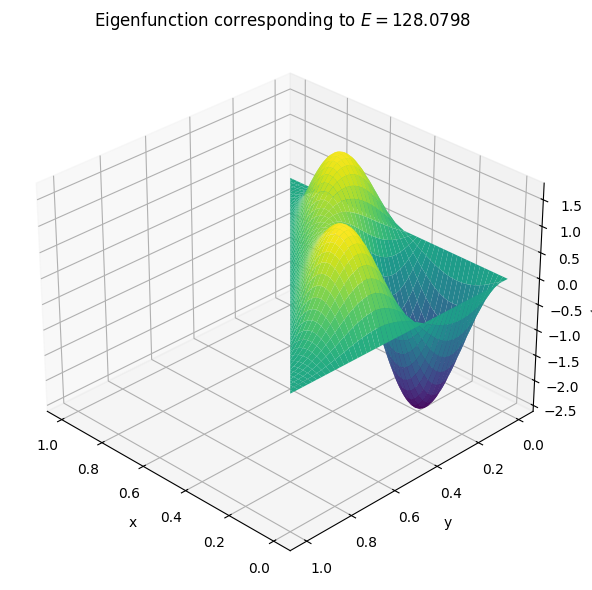

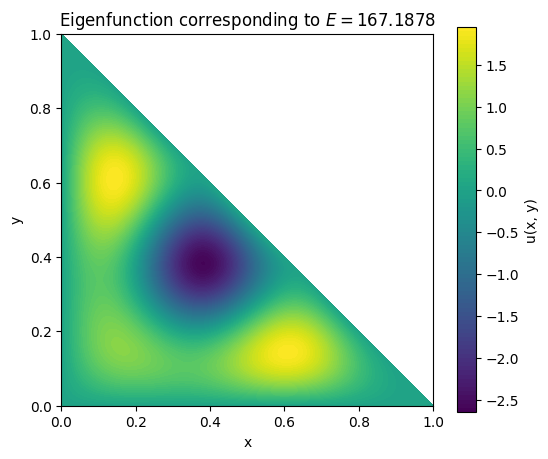

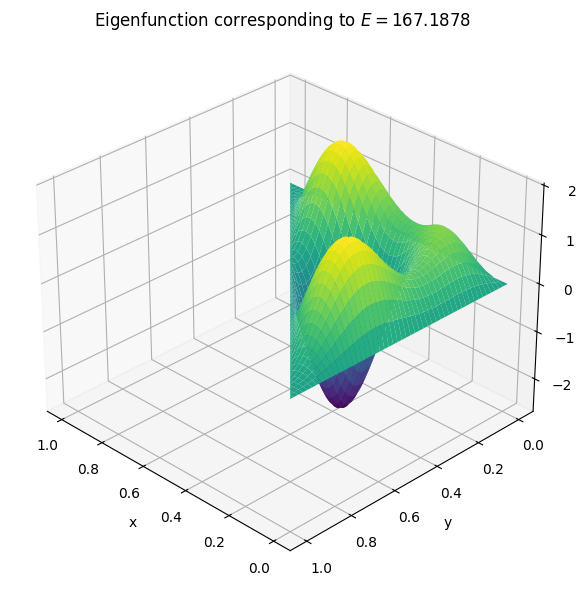

In [103]:
from mpl_toolkits.mplot3d import Axes3D

def plot_solution(model, grid_size=200, E_val=0):
    # Grid and mask
    x = torch.linspace(0, 1, grid_size)
    y = torch.linspace(0, 1, grid_size)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
    mask = (XY[:, 0] >= 0) & (XY[:, 1] >= 0) & (XY[:, 0] + XY[:, 1] <= 1)
    XY_inside = XY[mask]

    # Evaluate in the domain
    with torch.no_grad():
        u_pred = model(XY_inside).squeeze().cpu().numpy()

    # Matrix for full visualization
    U_plot = np.full(X.shape, np.nan)
    indices_inside = mask.nonzero().squeeze()
    U_plot_flat = U_plot.flatten()
    U_plot_flat[indices_inside] = u_pred
    U_plot = U_plot_flat.reshape(X.shape)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, U_plot, levels=100, cmap='viridis')
    plt.colorbar(label='u(x, y)')
    plt.title(fr"Eigenfunction corresponding to $E={E_val:.4f}$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.show()

    # Inicializate Z with NaN
    Z = np.full(X.shape, np.nan)
    indices_inside = mask.nonzero().squeeze()
    Z_flat = Z.flatten()
    Z_flat[indices_inside] = u_pred
    Z = Z_flat.reshape(X.shape)

    # Plot surface
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), Z, cmap='viridis', edgecolor='none')
    ax.set_title(fr"Eigenfunction corresponding to $E = {E_val:.4f}$")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x, y)')
    ax.view_init(elev=30, azim=135)
    plt.tight_layout()
    plt.show()


# Now, we plot the estimated eigenfunctions
for i in range(0, len(indices)):
  lam_init = refined_eigenvalues[i][0]
  model = trained_models[indices[i]]
  plot_solution(model, E_val=lam_init)

<font color='red'> **Example 5: Laplacian with a potential in the unit ball in $\mathbb{R}^4$** </font>

We consider the foloowing eigenvalue problem with Dirichlet boundary conditions
<font color='blue'>
$$
\begin{cases}
- \Delta u + V(x) u = E u & \text{in } B_4, \\
u = 0 & \text{on } \partial B_4,
\end{cases}
$$
</font>
where <font color='green'>$V : \mathbb{R}^n \to \mathbb{R}$ </font>is a given potential function and <font color='green'>$B_4$</font> is the unit ball in the 4-dimensional space. For simplicity we take $V=0$.

<font color='blue'>**Neuronal network**</font>


In this case, we only need to redefine the  `forward` method to adapt the model to the unit ball in $\mathbb{R}^3$.

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

class EigenFunctionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            nn.init.zeros_(m.bias)

    def forward(self, xyzw):
        x, y, z, w = xyzw[:, 0:1], xyzw[:, 1:2], xyzw[:, 2:3], xyzw[:, 3:4]
        u = self.net(xyzw)
        return (1 - x**2 - y**2 - z**2 - w**2) * u

<font color='blue'>**Sample and loss functions**</font>

We define the corresponding sampling function on the triangular domain. The loss function remains the same but without the potential term.

In [115]:
# ---------- Potential function ----------
def V1(xyzw, omega=1.0):
    x, y, z, w = xyzw[:, 0:1], xyzw[:, 1:2], xyzw[:, 2:3], xyzw[:, 3:4]
    return 0 * 0.5 * omega**2 * (x**2 + y**2 + z**2 + w**2)

# ---------- Sampling ----------
def sample_points(n):
    u = torch.rand(n, 1)
    theta1 = 2 * np.pi * torch.rand(n, 1)  # ángulo alrededor del eje w
    theta2 = torch.acos(2 * torch.rand(n, 1) - 1)  # ángulo polar entre [0, π]
    theta3 = 2 * np.pi * torch.rand(n, 1)  # ángulo sobre el plano x-y

    r = u ** (1/4)  # para que sea uniforme en volumen en 4D

    x = r * torch.sin(theta2) * torch.sin(theta3) * torch.cos(theta1)
    y = r * torch.sin(theta2) * torch.sin(theta3) * torch.sin(theta1)
    z = r * torch.sin(theta2) * torch.cos(theta3)
    w = r * torch.cos(theta2)

    return torch.cat([x, y, z, w], dim=1)

# ---------- Loss function ----------
def loss_fn(model, xyzw, E_val, V, mu=100.0):
    xyzw.requires_grad_(True)
    u = model(xyzw)

    grad_u = torch.autograd.grad(u, xyzw, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    laplace_u = sum([
        torch.autograd.grad(grad_u[:, i:i+1], xyzw, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, i:i+1]
        for i in range(4)
    ])

    residual = laplace_u - V * u + E_val * u
    loss_residual = (residual**2).mean()
    loss_norm = ((u**2).mean() - 1)**2

    return loss_residual + mu * loss_norm, loss_residual.item(), loss_norm.item()

<font color='blue'>**Training function**</font>

The training function is exaclty the same than before.

In [116]:
def train(model, E_val, V_tensor, n_epochs=2000, lr=1e-3, mu=100.0, early_stopping_patience=300, tol=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):
        xyzw = sample_points(512)
        V = V_tensor(xyzw).detach()
        optimizer.zero_grad()

        loss, res, norm = loss_fn(model, xyzw, E_val, V, mu)
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss - tol:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1

        if counter > early_stopping_patience:
            break

    return res, norm

In this particular case, the exact value of the sequence of eigenvalues is known. Here the first of them:

\begin{array}{|c|c|c|c|c|c|c|}
\hline
\# & \ell & n & \nu = \ell + 1 & j_{\nu,n} & \lambda = j_{\nu,n}^2 & \text{Multiplicidad} \\
\hline
1  & 0 & 1 & 1 & 3.8317 & 14.68  & 1   \\
2  & 1 & 1 & 2 & 5.1356 & 26.37  & 4   \\
3  & 2 & 1 & 3 & 6.3802 & 40.72  & 9   \\
4  & 0 & 2 & 1 & 7.0156 & 49.22  & 1   \\
5  & 3 & 1 & 4 & 7.5883 & 57.56  & 16  \\
6  & 1 & 2 & 2 & 8.4172 & 70.84  & 4   \\
7  & 4 & 1 & 5 & 8.7715 & 76.95  & 25  \\
8  & 2 & 2 & 3 & 9.7610 & 95.27  & 9   \\
9  & 5 & 1 & 6 & 9.9361 & 98.74  & 36  \\
10 & 0 & 3 & 1 & 10.1735 & 103.50 & 1   \\
\hline
\end{array}


<font color='blue'>**Main loop**</font>

Then, as before, we train the neural network over a range of eigenvalues $E \in [E_*, E^*]$ sampled at a fixed number of points. For each $E$, the model approximates the corresponding eigenfunction.

In [117]:
E_min, E_max, E_step = 0.0, 53.0, 70
lambdas = np.linspace(E_min, E_max, E_step)
residuals, trained_models = [], []

model = EigenFunctionNN()
for i, lam in enumerate(lambdas):
    if i > 0 and i % 60 !=0:
        new_model = EigenFunctionNN()
        new_model.load_state_dict(model.state_dict())
        model = new_model
    else:
        model = EigenFunctionNN()
    res, norm_err = train(model, E_val=lam, V_tensor=V1, mu=200 )
    print(f"E={lam:.2f} -> residual={res:.4e}, norm_err={norm_err:.2e}")

    residuals.append(res)
    trained_models.append(model)

E=0.00 -> residual=1.1634e+02, norm_err=1.34e-01
E=0.77 -> residual=8.8103e+01, norm_err=1.88e-01
E=1.54 -> residual=8.5178e+01, norm_err=1.61e-01
E=2.30 -> residual=7.7390e+01, norm_err=1.08e-01
E=3.07 -> residual=8.9962e+01, norm_err=5.57e-02
E=3.84 -> residual=8.0212e+01, norm_err=4.16e-02
E=4.61 -> residual=7.1645e+01, norm_err=3.79e-02
E=5.38 -> residual=5.2078e+01, norm_err=7.79e-02
E=6.14 -> residual=5.0482e+01, norm_err=3.77e-02
E=6.91 -> residual=4.1211e+01, norm_err=1.46e-02
E=7.68 -> residual=4.0941e+01, norm_err=3.48e-03
E=8.45 -> residual=2.9766e+01, norm_err=4.45e-03
E=9.22 -> residual=2.5945e+01, norm_err=8.18e-03
E=9.99 -> residual=1.7579e+01, norm_err=4.20e-03
E=10.75 -> residual=1.3094e+01, norm_err=2.95e-03
E=11.52 -> residual=8.1693e+00, norm_err=3.40e-04
E=12.29 -> residual=4.3091e+00, norm_err=2.63e-02
E=13.06 -> residual=2.3618e+00, norm_err=6.60e-05
E=13.83 -> residual=1.2610e+00, norm_err=3.47e-04
E=14.59 -> residual=1.4531e-01, norm_err=2.83e-03
E=15.36 -> res

<font color='blue'>**Plot of residuals vs E's**</font>

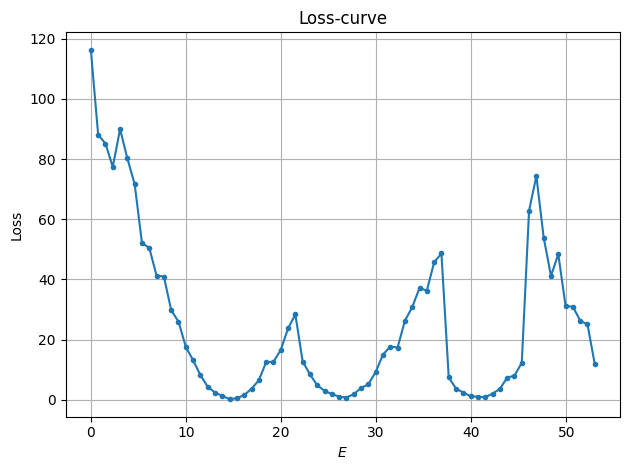

In [118]:
plt.plot(lambdas, residuals, '-o', markersize=3)
plt.xlabel(r"$E$")
plt.ylabel("Loss")
plt.title("Loss-curve")
plt.grid(True)
plt.tight_layout()
plt.show()

<font color='blue'>**Eigenvalue Refinement**</font>

After the initial sweep over $E$, a refinement step is performed to improve the approximation of the true eigenvalues.

In [119]:
refined_eigenvalues = []
indices = []
threshold = 2

for i in range(1, len(residuals) - 1):
    if residuals[i] < residuals[i - 1] and residuals[i] < residuals[i + 1] and residuals[i] < threshold:
        E_init, model = lambdas[i], trained_models[i]

        def objective(E_val):
            xy = sample_points(1024)
            V = V1(xy).detach()
            _, res, _ = loss_fn(model, xy, E_val, V, mu=0.0)
            return res

        result = minimize_scalar(
            objective,
            bounds=(lambdas[i - 1], lambdas[i + 1]),
            method='bounded'
        )
        refined_eigenvalues.append((result.x, result.fun))
        indices.append(i)

print("-- Refined eigenvalues found ---")
for idx, (lam, res) in enumerate(refined_eigenvalues, 1):
    print(f"{idx:2d}. E ≈ {lam:.6f}   Residual ≈ {res:.2e}")

-- Refined eigenvalues found ---
 1. E ≈ 14.666390   Residual ≈ 1.26e-01
 2. E ≈ 26.701958   Residual ≈ 6.15e-01
 3. E ≈ 40.778453   Residual ≈ 4.40e-01


<font color='blue'>**Plotting  $\Lambda(E)$ and $\bar\Lambda(E)$**</font>

The loss curve $\bar \Lambda(E)$ compared with the theoretical upper bound $\Lambda(E)$ in the interval $[E_*,E^*]$. To define the theoretical curve we use the exact values of eigenvalues.

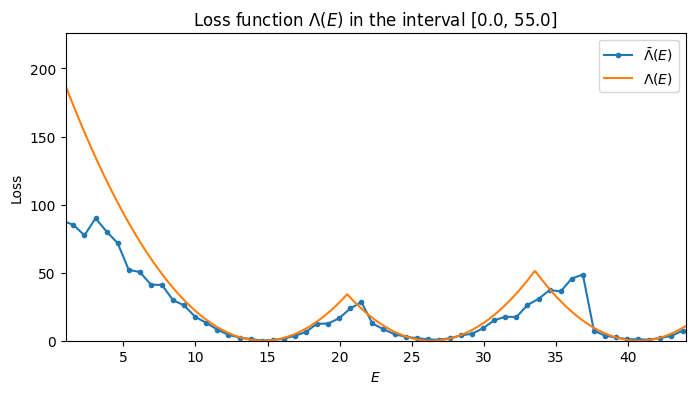

In [122]:
# Inverval [E_*, E^*]
E_min, E_max, E_step = 0.0, 55.0, 1000
t = np.linspace(E_min, E_max, E_step)

# Theoretical upper bound
L = np.minimum.reduce([
    (t - 14.68)**2,
    (t - 26.37	)**2,
    (t - 40.72)**2,
    (t - 49.22	)**2,
    (t - 57.56)**2,
    (t - 70.84	)**2,
    (t - 76.95	)**2
])

plt.figure(figsize=(8, 4))
plt.plot(lambdas, residuals, '-o', markersize=3, label=r'$\bar\Lambda(E)$')
plt.plot(t, L, label=r'$\Lambda(E)$')
plt.xlabel(r'$E$')
plt.ylabel(r'Loss')
plt.title(f'Loss function $\Lambda(E)$ in the interval [{E_min}, {E_max}]')
plt.grid(False)
plt.legend()
plt.xlim(1, 44)
plt.ylim(bottom=0)
plt.show()

<font color='red'> **Example 6: Laplacian with a potential in the unit ball in $\mathbb{R}^3$** </font>

We consider the foloowing eigenvalue problem with Dirichlet boundary conditions
<font color='blue'>
$$
\begin{cases}
- \Delta u + V(x) u = E u & \text{in } B_3, \\
u = 0 & \text{on } \partial B_3,
\end{cases}
$$
</font>
where <font color='green'>$V : \mathbb{R}^n \to \mathbb{R}$ </font>is a given potential function and <font color='green'>$B_3$</font> is the unit ball in the 3-dimensional space. For simplicity we take $V=0$.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

class EigenFunctionNN3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            nn.init.zeros_(m.bias)

    def forward(self, xyz):
        x, y, z = xyz[:, 0:1], xyz[:, 1:2], xyz[:, 2:3]
        u = self.net(xyz)
        return (1 - x**2 - y**2 - z**2) * u

<font color='blue'>**Sample and loss functions**</font>

We define the corresponding sampling function on the triangular domain. The loss function remains the same but without the potential term.

In [110]:
# ---------- Potential function ----------
def V1(xyz, omega=1.0):
    x, y, z = xyz[:, 0:1], xyz[:, 1:2], xyz[:, 2:3]
    return 0*0.5 * omega**2 * (x**2 + y**2 + z**2)

# ---------- Sampling ----------
def sample_points(n):
    u = torch.rand(n, 1)
    theta = 2 * np.pi * torch.rand(n, 1)
    phi = torch.acos(1 - 2 * torch.rand(n, 1))  # Distribución uniforme en la esfera

    r = u**(1/3)  # Distribución uniforme en volumen
    x = r * torch.sin(phi) * torch.cos(theta)
    y = r * torch.sin(phi) * torch.sin(theta)
    z = r * torch.cos(phi)

    return torch.cat([x, y, z], dim=1)

# ---------- Loss function ----------
def loss_fn(model, xyz, E_val, V, mu=100.0):
    xyz.requires_grad_(True)
    u = model(xyz)

    grad_u = torch.autograd.grad(u, xyz, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    laplace_u = sum([
        torch.autograd.grad(grad_u[:, i:i+1], xyz, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, i:i+1]
        for i in range(3)
    ])

    residual = laplace_u - V * u + E_val * u
    loss_residual = (residual**2).mean()
    loss_norm = ((u**2).mean() - 1)**2

    return loss_residual + mu * loss_norm, loss_residual.item(), loss_norm.item()

<font color='blue'>**Training function**</font>

The training function is exaclty the same than before.

In [41]:
def train(model, E_val, V_tensor, n_epochs=2000, lr=1e-3, mu=100.0, early_stopping_patience=300, tol=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):
        xyz = sample_points(512)
        V = V_tensor(xyz).detach()
        optimizer.zero_grad()
        loss, res, norm = loss_fn(model, xyz, E_val, V, mu)
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss - tol:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
        if counter > early_stopping_patience:
            break

    return res, norm

In this particular case, the exact value of the sequence of eigenvalues is known. Here the first of them:


\begin{array}{|c|c|c|c|c|c|}
\hline
\# & \ell & n & j_{\ell,n} & E_{\ell,n} = j_{\ell,n}^2 & \text{Multiplicidad} \\
\hline
1 & 0 & 1 & 3.1416 & 9.8696 & 1 \\
2 & 1 & 1 & 4.4934 & 20.1907 & 3 \\
3 & 2 & 1 & 5.7635 & 33.2251 & 5 \\
4 & 0 & 2 & 6.2832 & 39.4784 & 1 \\
5 & 3 & 1 & 6.9879 & 48.9737 & 7 \\
6 & 1 & 2 & 7.7253 & 59.6946 & 3 \\
7 & 4 & 1 & 8.1826 & 66.9489 & 9 \\
8 & 0 & 3 & 9.4248 & 88.8264 & 1 \\
9 & 5 & 1 & 9.6170 & 92.5013 & 11 \\
10 & 2 & 2 & 9.7610 & 95.2764 & 5 \\
\hline
\end{array}


<font color='blue'>**Main loop**</font>

Then, as before, we train the neural network over a range of eigenvalues $E \in [E_*, E^*]$ sampled at a fixed number of points. For each $E$, the model approximates the corresponding eigenfunction.

In [42]:
E_min, E_max, E_step = 0.0, 55.0, 100
lambdas = np.linspace(E_min, E_max, E_step)
residuals, trained_models = [], []

model = EigenFunctionNN()
for i, lam in enumerate(lambdas):
    if i > 0 and i % 50 !=0:
        new_model = EigenFunctionNN()
        new_model.load_state_dict(model.state_dict())
        model = new_model
    else:
        model = EigenFunctionNN()
    res, norm_err = train(model, E_val=lam, V_tensor=V1, mu=400)
    print(f"E={lam:.2f} -> residual={res:.4e}, norm_err={norm_err:.2e}")

    residuals.append(res)
    trained_models.append(model)

E=0.00 -> residual=9.2014e+01, norm_err=4.03e-03
E=0.56 -> residual=8.8672e+01, norm_err=7.54e-05
E=1.11 -> residual=6.8958e+01, norm_err=1.43e-02
E=1.67 -> residual=6.5174e+01, norm_err=1.65e-03
E=2.22 -> residual=5.2169e+01, norm_err=1.51e-02
E=2.78 -> residual=4.8787e+01, norm_err=1.86e-03
E=3.33 -> residual=4.0476e+01, norm_err=5.08e-03
E=3.89 -> residual=2.9201e+01, norm_err=3.36e-02
E=4.44 -> residual=3.0766e+01, norm_err=9.82e-04
E=5.00 -> residual=2.0892e+01, norm_err=1.58e-02
E=5.56 -> residual=1.8490e+01, norm_err=1.29e-03
E=6.11 -> residual=1.1342e+01, norm_err=4.60e-02
E=6.67 -> residual=1.0085e+01, norm_err=1.88e-03
E=7.22 -> residual=6.6562e+00, norm_err=1.01e-02
E=7.78 -> residual=4.6326e+00, norm_err=2.00e-05
E=8.33 -> residual=3.3158e+00, norm_err=9.73e-03
E=8.89 -> residual=1.2610e+00, norm_err=2.64e-03
E=9.44 -> residual=3.1275e-01, norm_err=1.16e-03
E=10.00 -> residual=2.8627e-01, norm_err=1.56e-03
E=10.56 -> residual=5.8882e-01, norm_err=2.93e-03
E=11.11 -> residua

<font color='blue'>**Plot of residuals vs E's**</font>

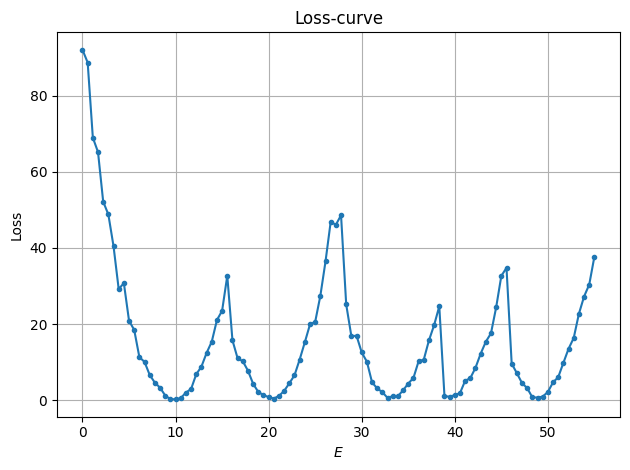

In [111]:
plt.plot(lambdas, residuals, '-o', markersize=3)
plt.xlabel(r"$E$")
plt.ylabel("Loss")
plt.title("Loss-curve")
plt.grid(True)
plt.tight_layout()
plt.show()

<font color='blue'>**Eigenvalue Refinement**</font>

After the initial sweep over $E$, a refinement step is performed to improve the approximation of the true eigenvalues.

In [96]:
refined_eigenvalues = []
indices = []
threshold = 1.3

for i in range(1, len(residuals) - 1):
    if residuals[i] < residuals[i - 1] and residuals[i] < residuals[i + 1] and residuals[i] < threshold:
        lam_init = lambdas[i]
        model = trained_models[i]

        def objective(E_val):
            xyz = sample_points(1024)
            V = V1(xyz).detach()
            _, res, _ = loss_fn(model, xyz, E_val, V, mu=0.0)
            return res

        result = minimize_scalar(
            objective,
            bounds=(lambdas[i - 1], lambdas[i + 1]),
            method='bounded'
        )
        refined_eigenvalues.append((result.x, result.fun))
        indices.append(i)

print("-- Refined eigenvalues found ---")
for idx, (lam, res) in enumerate(refined_eigenvalues, 1):
    print(f"{idx:2d}. E ≈ {lam:.6f}   Residual ≈ {res:.2e}")

-- Refined eigenvalues found ---
 1. E ≈ 9.921321   Residual ≈ 2.41e-01
 2. E ≈ 20.262298   Residual ≈ 3.41e-01
 3. E ≈ 33.092225   Residual ≈ 6.63e-01
 4. E ≈ 39.438649   Residual ≈ 8.92e-01
 5. E ≈ 49.081958   Residual ≈ 1.01e+00


<font color='blue'>**Plotting  $\Lambda(E)$ and $\bar\Lambda(E)$**</font>

The loss curve $\bar \Lambda(E)$ compared with the theoretical upper bound $\Lambda(E)$ in the interval $[E_*,E^*]$. To define the theoretical curve we use the exact values of eigenvalues.

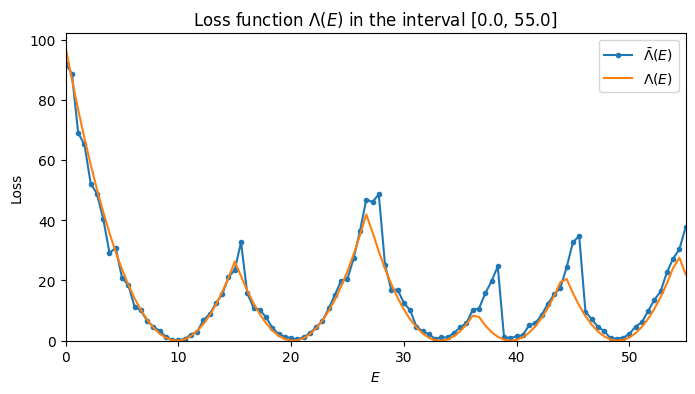

In [112]:
# Inverval [E_*, E^*]
E_min, E_max, E_step = 0.0, 55.0, 100
t = np.linspace(E_min, E_max, E_step)

# Theoretical upper bound
L = np.minimum.reduce([
    (t - 9.8696)**2,
    (t - 20.1907	)**2,
    (t - 33.2251)**2,
    (t - 39.4784	)**2,
    (t - 48.9737)**2,
    (t - 59.6946	)**2,
    (t - 66.9489	)**2
])

plt.figure(figsize=(8, 4))
plt.plot(lambdas, residuals, '-o', markersize=3, label=r'$\bar\Lambda(E)$')
plt.plot(t, L, label=r'$\Lambda(E)$')
plt.xlabel(r'$E$')
plt.ylabel(r'Loss')
plt.title(f'Loss function $\Lambda(E)$ in the interval [{E_min}, {E_max}]')
plt.grid(False)
plt.legend()
plt.xlim(0, 55)
plt.ylim(bottom=0)
plt.show()